In [1]:
!pip3 install matplotlib

You should consider upgrading via the '/Users/arush/pyVirtualEnvs/jupyterenv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import utils
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter

[nltk_data] Downloading package stopwords to /Users/arush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def create_matrix(instances, vocabulary):
    matrix = np.zeros((len(instances), len(vocabulary)), dtype=int)
    word_to_index = {word: i for i, word in enumerate(vocabulary)}
    
    for i, instance in enumerate(instances):
        for word in instance:
            if word in word_to_index:
                matrix[i][word_to_index[word]] += 1
    
    return matrix

In [4]:
def compute_word_probabilities(matrix, alpha):
    word_count_vector = np.sum(matrix, axis=0)
    total_words = np.sum(word_count_vector)
    word_probabilities = (word_count_vector + alpha) / (total_words + alpha * len(word_count_vector))
    return word_probabilities, total_words

In [5]:
def compute_class_probability_matrix(instances, vocabulary, alpha):
    matrix = create_matrix(instances, vocabulary)
    word_probabilities, total_words = compute_word_probabilities(matrix, alpha)
    return word_probabilities, total_words

In [6]:
def test_prob(instance, class_probabilities, prior_probability, word_to_index):
    prob = prior_probability
    for word in instance:
        if word in word_to_index:
            word_prob = class_probabilities[word_to_index[word]]
            prob *= word_prob
        else:
            prob *= 0
            break
    return prob

In [7]:
def test_log_prob(instance, class_probabilities, prior_probability, word_to_index):
    log_prob = np.log(prior_probability)
    for word in instance:
        if word in word_to_index:
            word_prob = class_probabilities[word_to_index[word]]
            if word_prob > 0:
                log_prob += np.log(word_prob)
            else:
                log_prob += np.log(1e-8)  
        else:
            log_prob += np.log(1e-8)  
    return log_prob

In [8]:
def test_log_prob_with_smoothing(instance, class_probabilities, prior_probability, total_words, word_to_index, alpha):
    log_prob = np.log(prior_probability)
    for word in instance:
        if word in word_to_index:
            word_prob = class_probabilities[word_to_index[word]]
            log_prob += np.log(word_prob)
        else:
            log_prob += np.log(alpha / (total_words + alpha * len(word_to_index)))  
    return log_prob

In [9]:
def load_dataset(test_size, train_size=1.0, pos_size=None, neg_size=None):
    if pos_size != None and neg_size != None:
        positive_instances, negative_instances, vocab = utils.load_training_set(pos_size, neg_size) 
        positive_test_instances, negative_test_instances = utils.load_test_set(test_size, test_size)
    else:
        positive_instances, negative_instances, vocab = utils.load_training_set(train_size, train_size) 
        positive_test_instances, negative_test_instances = utils.load_test_set(test_size, test_size)
    return positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances

In [10]:
def confusion_matrix(true_label, pred_label):
  classes = [1,0]
  matrix = np.zeros((len(classes), len(classes)))
  for y, y_hat in zip(true_label, pred_label):
    if y in classes and y_hat in classes:
      matrix[classes.index(y), classes.index(y_hat)] += 1
  return matrix

def accuracy(true_label, pred_label):
    confusion = confusion_matrix(true_label, pred_label)
    correct = np.sum(np.diag(confusion))
    total = np.sum(confusion)
    return correct / total if total > 0 else 0.0

def precision(true_label, pred_label, positive_class=0):
    confusion = confusion_matrix(true_label, pred_label)
    true_positives = confusion[positive_class, positive_class]
    predicted_positives = np.sum(confusion[:, positive_class])
    return true_positives / predicted_positives if predicted_positives > 0 else 0.0

def recall(true_label, pred_label, positive_class=0):
    confusion = confusion_matrix(true_label, pred_label)
    true_positives = confusion[positive_class, positive_class]
    actual_positives = np.sum(confusion[positive_class, :])
    return true_positives / actual_positives if actual_positives > 0 else 0.0

In [11]:
def evaluate_classifier(positive_instances, negative_instances, positive_probabilities, negative_probabilities, vocab):
    word_to_index = {word: i for i, word in enumerate(vocab)}
    positive_prior = len(positive_instances) / (len(positive_instances) + len(negative_instances))
    negative_prior = 1 - positive_prior

    true_labels = []
    predicted_labels = []

    random.seed(10)
    
    for instance in positive_instances:
        pos_prob = test_prob(instance, positive_probabilities, positive_prior, word_to_index)
        neg_prob = test_prob(instance, negative_probabilities, negative_prior, word_to_index)
        if pos_prob > neg_prob:
            predicted_labels.append(1)
        elif pos_prob < neg_prob:
            predicted_labels.append(0)
        else: 
            predicted_labels.append(random.choice([0, 1]))
        true_labels.append(1)

    for instance in negative_instances:
        pos_prob = test_prob(instance, positive_probabilities, positive_prior, word_to_index)
        neg_prob = test_prob(instance, negative_probabilities, negative_prior, word_to_index)
        if pos_prob > neg_prob:
            predicted_labels.append(1)
        elif pos_prob < neg_prob:
            predicted_labels.append(0)
        else: 
            predicted_labels.append(random.choice([0, 1]))
        true_labels.append(0)

    accuracy_score = accuracy(true_labels, predicted_labels)
    precision_score = precision(true_labels, predicted_labels)
    recall_score = recall(true_labels, predicted_labels)
    confusion = confusion_matrix(true_labels, predicted_labels)
    
    return accuracy_score, precision_score, recall_score, confusion

In [12]:
def evaluate_log_classifier(positive_instances, negative_instances, positive_probabilities, negative_probabilities, vocab):
    word_to_index = {word: i for i, word in enumerate(vocab)}
    positive_prior = len(positive_instances) / (len(positive_instances) + len(negative_instances))
    negative_prior = 1 - positive_prior

    true_labels = []
    predicted_labels = []

    random.seed(10)
    
    for instance in positive_instances:
        pos_log_prob = test_log_prob(instance, positive_probabilities, positive_prior, word_to_index)
        neg_log_prob = test_log_prob(instance, negative_probabilities, negative_prior, word_to_index)
        if pos_log_prob > neg_log_prob:
            predicted_labels.append(1)
        elif pos_log_prob < neg_log_prob:
            predicted_labels.append(0)
        else: 
            predicted_labels.append(random.choice([0, 1]))
        true_labels.append(1)

    for instance in negative_instances:
        pos_log_prob = test_log_prob(instance, positive_probabilities, positive_prior, word_to_index)
        neg_log_prob = test_log_prob(instance, negative_probabilities, negative_prior, word_to_index)
        if pos_log_prob > neg_log_prob:
            predicted_labels.append(1)
        elif pos_log_prob < neg_log_prob:
            predicted_labels.append(0)
        else: 
            predicted_labels.append(random.choice([0, 1]))
        true_labels.append(0)

    accuracy_score = accuracy(true_labels, predicted_labels)
    precision_score = precision(true_labels, predicted_labels)
    recall_score = recall(true_labels, predicted_labels)
    confusion = confusion_matrix(true_labels, predicted_labels)
    
    return accuracy_score, precision_score, recall_score, confusion

In [13]:
def evaluate_log_classifier_with_smoothing(positive_instances, negative_instances, positive_probabilities, negative_probabilities, 
                                           total_positive_words, total_negative_words, vocab, alpha):
    word_to_index = {word: i for i, word in enumerate(vocab)}
    positive_prior = len(positive_instances) / (len(positive_instances) + len(negative_instances))
    negative_prior = 1 - positive_prior

    true_labels = []
    predicted_labels = []

    random.seed(10)
    
    for instance in positive_instances:
        pos_log_prob = test_log_prob_with_smoothing(instance, positive_probabilities, positive_prior, total_positive_words, word_to_index, alpha)
        neg_log_prob = test_log_prob_with_smoothing(instance, negative_probabilities, negative_prior, total_negative_words, word_to_index, alpha)
        if pos_log_prob > neg_log_prob:
            predicted_labels.append(1)
        elif pos_log_prob < neg_log_prob:
            predicted_labels.append(0)
        else: 
            predicted_labels.append(random.choice([0, 1]))
        true_labels.append(1)

    for instance in negative_instances:
        pos_log_prob = test_log_prob_with_smoothing(instance, positive_probabilities, positive_prior, total_positive_words, word_to_index, alpha)
        neg_log_prob = test_log_prob_with_smoothing(instance, negative_probabilities, negative_prior, total_negative_words, word_to_index, alpha)
        if pos_log_prob > neg_log_prob:
            predicted_labels.append(1)
        elif pos_log_prob < neg_log_prob:
            predicted_labels.append(0)
        else: 
            predicted_labels.append(random.choice([0, 1]))
        true_labels.append(0)

    accuracy_score = accuracy(true_labels, predicted_labels)
    precision_score = precision(true_labels, predicted_labels)
    recall_score = recall(true_labels, predicted_labels)
    confusion = confusion_matrix(true_labels, predicted_labels)
    return accuracy_score, precision_score, recall_score, confusion

In [34]:
def run_experiment(positive_instances, negative_instances, vocab, positive_test_instances, 
                   negative_test_instances, alpha, use_log_prob = False):
    positive_probabilities, total_positive_words = compute_class_probability_matrix(positive_instances, vocab, alpha)
    negative_probabilities, total_negative_words = compute_class_probability_matrix(negative_instances, vocab, alpha)
    
    if use_log_prob == True and alpha==0:
            accuracy, precision, recall, confusion = evaluate_log_classifier(positive_test_instances, negative_test_instances, 
                                            positive_probabilities, negative_probabilities, vocab)
    elif use_log_prob == True and alpha>0:
            accuracy, precision, recall, confusion = evaluate_log_classifier_with_smoothing(positive_test_instances, negative_test_instances, 
                                            positive_probabilities, negative_probabilities,total_positive_words, total_negative_words, vocab, alpha)
    else:
        accuracy, precision, recall, confusion = evaluate_classifier(positive_test_instances, negative_test_instances, 
                                                                     positive_probabilities, negative_probabilities, vocab)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Confusion Matrix: \n", confusion)

    return accuracy, precision, recall, confusion
   

## Question 1

# Posterior Probability

In [29]:
train_size = 0.2
test_size = 0.2
positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances = load_dataset(0.2,0.2)

In [35]:
alpha = 0
run_experiment(positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances, alpha)

Accuracy: 0.5109674892283588
Precision: 0.5196911196911197
Recall: 0.5178914967295114
Confusion Matrix: 
 [[1346. 1253.]
 [1244. 1263.]]


(0.5109674892283588,
 0.5196911196911197,
 0.5178914967295114,
 array([[1346., 1253.],
        [1244., 1263.]]))

# Log Probability

In [17]:
run_experiment(positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances, alpha, True)

(0.7518072289156627,
 0.7806367204535543,
 0.7094728497820055,
 array([[1790.,  733.],
        [ 503., 1954.]]))

## Question 2

In [18]:
train_size = 0.2
test_size = 0.2
positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances = load_dataset(train_size, test_size)

In [19]:
alpha = 1
run_experiment(positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances, alpha, True)

(0.8084036992360274,
 0.8473782771535581,
 0.7427164546573656,
 array([[1810.,  627.],
        [ 326., 2211.]]))

In [20]:
#function to compute accuracy by varying alpha
def vary_alpha(train_size, test_size, alphas):
    accuracies = []
    positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances = load_dataset(0.2,0.2)
    for alpha in alphas:
        accuracy, _, _, _ = run_experiment(positive_instances, negative_instances, vocab, 
                                           positive_test_instances, negative_test_instances, alpha, True)
        accuracies.append(accuracy)
    return accuracies

In [21]:
train_size = 0.2
test_size = 0.2
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
accuracies = vary_alpha(train_size, test_size, alphas)
print(accuracies)

[0.7199437072778448, 0.7400482509047045, 0.7605548854041013, 0.7880981101728991, 0.8084036992360274, 0.8228789706473663, 0.8118214716525934, 0.7521109770808203]


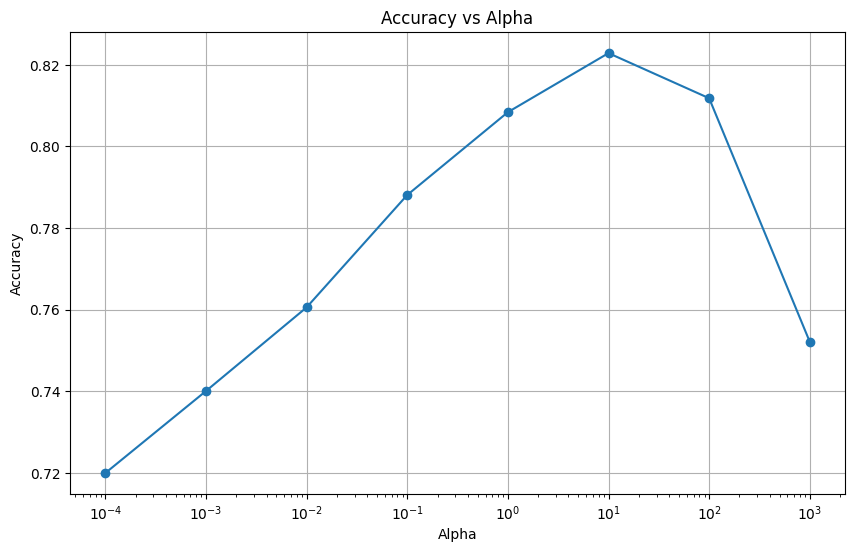

In [22]:
#plotting graph
plt.figure(figsize=(10, 6))
plt.plot(alphas, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha')
plt.grid(True)
plt.show()

## Question 3

In [23]:
train_size = 1.0
test_size = 1.0
alpha = 10
positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances = load_dataset(train_size, test_size)
run_experiment(positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances, alpha, True)

(0.83692,
 0.8686214442013129,
 0.79392,
 array([[ 9924.,  2576.],
        [ 1501., 10999.]]))

## Question 4

In [24]:
train_size = 0.5
test_size = 1.0
alpha = 10
positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances = load_dataset(train_size, test_size)
run_experiment(positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances, alpha, True)

(0.8311450624651866,
 0.8590909090909091,
 0.7887640449438202,
 array([[4914., 1316.],
        [ 806., 5531.]]))

## Question 6

In [25]:
pos_size = 0.1
neg_size = 0.5
test_size = 1.0
alpha = 10
positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances = load_dataset(test_size = test_size,
                                                                                                    pos_size = pos_size, neg_size = neg_size)
run_experiment(positive_instances, negative_instances, vocab, positive_test_instances, negative_test_instances, alpha, True)

(0.50024,
 0.875,
 0.00056,
 array([[7.0000e+00, 1.2493e+04],
        [1.0000e+00, 1.2499e+04]]))